In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, roc_curve, auc
from GPyOpt.methods import BayesianOptimization
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('part3_training_data.csv')
X = data.drop(columns=["claim_amount", "made_claim"])
y_raw = data["made_claim"]
X_train, X_val, y_train, y_val = train_test_split(X, y_raw, test_size=0.1, random_state=42)
claim_raw=data["claim_amount"]

In [4]:
from part3_pricing_model import *

In [5]:
pricemodel=PricingModel()

In [6]:
pricemodel.fit(X, y_raw, claim_raw)

Net(
  (layers): ModuleList(
    (0): Linear(in_features=59, out_features=30, bias=True)
    (1): Linear(in_features=30, out_features=16, bias=True)
  )
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
  (first_bn_layer): BatchNorm1d(59, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_layers): ModuleList(
    (0): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (dropout_layers): ModuleList(
    (0): Dropout(p=0.01, inplace=False)
    (1): Dropout(p=0.01, inplace=False)
  )
)

In [7]:
preds=pricemodel.predict_claim_probability(X)

In [8]:
preds

array([1., 1., 1., ..., 1., 1., 1.])

In [9]:
pricemodel.predict_premium(X)

array([757.56515, 757.56515, 757.56515, ..., 757.56515, 757.56515,
       757.56515])

In [10]:
pricemodel.save_model()

In [11]:
import pandas as pd
from part2_claim_classifier import *
from part3_pricing_model import *
from part3_pricing_model import load_model as part3_loader
classifier = part3_loader()
data = pd.read_csv("part3_training_data.csv")
X = data.drop(columns=["claim_amount", "made_claim"])
res1 = classifier.predict_premium(X)
res2 = classifier.predict_claim_probability(X)
print(res1)
print(res2)

[734.8381955 734.8381955 734.8381955 ... 734.8381955 734.8381955
 734.8381955]
[1. 1. 1. ... 1. 1. 1.]


In [12]:
class TableDataset(Dataset):

    def __init__(self, data, output_col=None):
        # Characterizes a Dataset for PyTorch
        self.n = data.shape[0]
        self.X = data.astype(np.float64).values
        if output_col:
            self.y = data[output_col].astype(np.float64).values.reshape(-1, 1)
        else:
            self.y = np.zeros((self.n, 1))

    def __len__(self):
        # Denotes the total number of samples.
        return self.n

    def __getitem__(self, idx):
        # Generates one sample of data.
        return [self.X[idx], self.y[idx]]

In [13]:
class Net(nn.Module):
    def __init__(self, input_size, layer_sizes, output_size, layer_dropouts):
        super().__init__()

        first_layer = nn.Linear(input_size, layer_sizes[0]) #59, 40
#         l1=nn.Linear(input_size, layer_sizes[0])
#         a1=nn.ReLU()
#         l2=nn.Linear(layer_sizes[0], layer_sizes[1])
        self.layers = nn.ModuleList([first_layer] +
                [nn.Linear(layer_sizes[i], layer_sizes[i+1]) for i in range(len(layer_sizes)-1)]) #40, 65
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight.data)
        # output layers
        self.output_layer = nn.Linear(layer_sizes[-1], output_size)#65, 1
        nn.init.kaiming_normal_(self.output_layer.weight.data)
        # batch norm layers
        self.first_bn_layer = nn.BatchNorm1d(input_size) #32, 59
        self.bn_layers = nn.ModuleList([nn.BatchNorm1d(size) for size in layer_sizes]) #32, 40 and 32, 65
        # dropout layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(size) for size in layer_dropouts])

    def forward(self, data):
        x=self.first_bn_layer(data)
        for layer, dropout_layer, bn_layer in zip(self.layers, self.dropout_layers, self.bn_layers):
            x = F.relu(layer(x))
            x = bn_layer(x)
            x = dropout_layer(x)
        x = F.sigmoid(self.output_layer(x))
        return x

In [14]:
use_data=pd.read_csv('cleandata.csv')
y=use_data["made_claim"]

In [16]:
X_train, X_val, y_train, y_val = train_test_split(use_data, y, test_size=0.1, random_state=0)

In [17]:
X_train.shape

(71478, 60)

In [18]:
X_val.shape

(7942, 60)

In [19]:
y_train.shape

(71478,)

In [20]:
y_val.shape

(7942,)

In [21]:
output_feature="made_claim"
traindataset = TableDataset(X_train, output_feature)
valdataset=TableDataset(X_val, output_feature)

In [22]:
batchsize=640
traindataloader = DataLoader(traindataset, batchsize, shuffle=True, num_workers=1)
valdataloader=DataLoader(valdataset, batchsize, shuffle=True, num_workers=1)

In [26]:
model = Net(input_size=59, layer_sizes=[30, 16], output_size=1, layer_dropouts=[0.005,0.01])

In [27]:
no_of_epochs = 10
criterion=nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [28]:
losses = []
y_preds = []
y_true =[]
for epoch in range(no_of_epochs):
    batch_losses=[]
    model.train()
    for x, y in traindataloader:
        preds = model((x[:, :-1]).float())
        loss = criterion(preds, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_losses.append(loss)
    average_batch_loss = sum(batch_losses)/len(batch_losses)
    losses.append(average_batch_loss)
    
model.eval()
with torch.set_grad_enabled(False):
    acc_val = []
    for x_t, y_t in valdataloader:
        val_preds=model((x_t[:, :-1]).float())
        y_true.append(y_t.numpy())
        y_preds.append(val_preds.numpy())
        try:
            roc_auc = roc_auc_score(y_t, val_preds)
            acc_val.append(roc_auc)
        except ValueError:
            pass

Text(0, 0.5, 'Binary Cross Entropy Loss / ROC Accuracy')

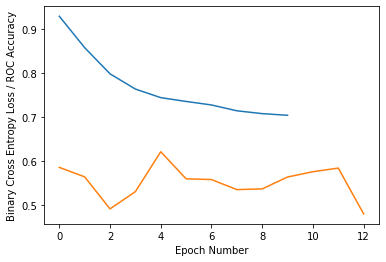

In [29]:
plt.plot(losses, label="Training Loss (avg. over each Epoch")
plt.plot(acc_val, label="Accuracy on Validation Set")
plt.xlabel('Epoch Number')
plt.ylabel('Binary Cross Entropy Loss / ROC Accuracy')

In [30]:
def new_array(y):
    one_array=[]
    y=np.array(y)
    for batch in y:
        for x in batch.flatten():
            one_array.append(x)
    one_array=np.array(one_array)
    return one_array
#     len=one_array.shape[0]/no_of_epochs
#     new_array=[]
#     for i in range(no_of_epochs):
#         p=one_array[int(len*i):int(len*(i+1))]
#         new_array.append(p)
#     new_array=np.array(new_array)
#     return new_array

In [31]:
preds=new_array(y_preds)

In [32]:
preds.shape

(7942,)

In [33]:
true=new_array(y_true)
true.shape

(7942,)

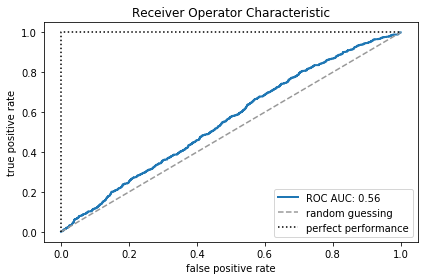

In [34]:
# calling the roc_curve, extract the probability of 
# the positive class from the predicted probability

test_pred = preds
fpr, tpr, thresholds = roc_curve(true, test_pred, pos_label = 1)

# AUC score that summarizes the ROC curve
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, lw = 2, label = 'ROC AUC: {:.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1],
         linestyle = '--',
         color = (0.6, 0.6, 0.6),
         label = 'random guessing')
plt.plot([0, 0, 1], [0, 1, 1],
         linestyle = ':',
         color = 'black', 
         label = 'perfect performance')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Receiver Operator Characteristic')
plt.legend(loc = "lower right")
plt.tight_layout()
plt.show()

In [ ]:
data=pd.read_csv('part3_training_data.csv')

In [3]:
X = data.drop(columns=["claim_amount", "made_claim"])
y = data["made_claim"]
claims =data["claim_amount"]

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [1]:
import pandas as pd
from part2_claim_classifier import *
from part3_pricing_model import *

In [2]:
ClaimClassifierHyperParameterSearch()



Confusion Matrix
[[1237  905]
 [ 800 1417]]


Confusion Report: Accuracy, F1 Score and ROC Accuracy:
              precision    recall  f1-score   support

         0.0       0.61      0.58      0.59      2142
         1.0       0.61      0.64      0.62      2217

    accuracy                           0.61      4359
   macro avg       0.61      0.61      0.61      4359
weighted avg       0.61      0.61      0.61      4359



ROC Accuracy:
0.6083248364749598
Epoch 20  -- Accuracy:  0.6083248364749598


Confusion Matrix
[[1334  808]
 [ 944 1273]]


Confusion Report: Accuracy, F1 Score and ROC Accuracy:
              precision    recall  f1-score   support

         0.0       0.59      0.62      0.60      2142
         1.0       0.61      0.57      0.59      2217

    accuracy                           0.60      4359
   macro avg       0.60      0.60      0.60      4359
weighted avg       0.60      0.60      0.60      4359



ROC Accuracy:
0.5984909074139353
Epoch 40  -- Accuracy:  0.5

{'Epoch': 40,
 'BatchSize': 32,
 'LearningRate': 0.1,
 'ActFunc': None,
 'Layers': None,
 'Neurons': 18}

In [6]:
model = PricingModel()

In [8]:
from sklearn.metrics import roc_auc_score

In [13]:
import pandas as pd
from part2_claim_classifier import *
from part3_pricing_model import *
from part3_pricing_model import load_model as part3_loader
classifier = part3_loader()
data = pd.read_csv("part3_training_data.csv")
X = data.drop(columns=["claim_amount", "made_claim"])
res1 = classifier.predict_premium(X)
res2 = classifier.predict_claim_probability(X)
print(res1)
print(res2)

FileNotFoundError: [Errno 2] No such file or directory: 'part3_pricing_model.pickle'

In [4]:
objects = []
for col in X.columns:
    if X[col].dtype != np.float64 and X[col].dtype != np.int64:
        objects.append(col)
cat_features = []
for obj in objects:
    if X[obj].nunique() < 20:
        cat_features.append(obj)
data_new = pd.concat([X, pd.get_dummies(X[cat_features], prefix=cat_features, dummy_na=True)],
                     axis=1).drop(cat_features, axis=1)
other_objects = []
for obj in objects[1:]:
    if obj not in cat_features:
        other_objects.append(obj)
data_new[other_objects] = data_new[other_objects].astype('|S')
label_encoders = {}
for o in other_objects:
    label_encoders[o] = LabelEncoder()
    data_new[o] = label_encoders[o].fit_transform(data_new[o])
X_clean = data_new.drop(['id_policy'], axis=1)
X_clean.reset_index()
X_clean = X_clean.fillna(0)
X_clean

,pol_bonus,pol_duration,pol_sit_duration,pol_insee_code,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_make,vh_model,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,commune_code,canton_code,city_district_code,regional_department_code,pol_coverage_Maxi,pol_coverage_Median1,pol_coverage_Median2,pol_coverage_Mini,pol_coverage_nan,pol_pay_freq_Biannual,pol_pay_freq_Monthly,pol_pay_freq_Quarterly,pol_pay_freq_Yearly,pol_pay_freq_nan,pol_payd_No,pol_payd_Yes,pol_payd_nan,pol_usage_AllTrips,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,pol_usage_nan,drv_drv2_No,drv_drv2_Yes,drv_drv2_nan,drv_sex1_F,drv_sex1_M,drv_sex1_nan,drv_sex2_F,drv_sex2_M,drv_sex2_nan,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_fuel_nan,vh_type_Commercial,vh_type_Tourism,vh_type_nan
0,0.5,36,6,12084,77,0,55,0,15,1598,111,72,802,16,15,185,17517,1260,526.0,3216.0,4.8,269.0,20.0,5.0,68,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
1,0.5,15,5,4271,52,55,33,35,12,2184,112,63,235,12,9,180,21500,1480,57.0,4912.0,141.3,19.0,99.0,1.0,27,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
2,0.5,16,6,1806,52,0,34,0,20,2496,112,48,404,32,19,130,23600,2931,257.0,4488.0,5.3,80.0,27.0,1.0,12,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
3,0.5,11,7,1438,67,0,46,0,12,1149,75,72,359,14,12,170,13050,930,109.0,1339.0,61.2,387.0,99.0,3.0,9,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
4,0.5,16,6,9789,60,37,35,14,23,1905,93,20,975,23,18,185,17974,1035,24.0,1849.0,9.7,153.0,19.0,6.0,59,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79415,0.5,12,7,3031,40,0,21,0,11,1896,131,94,691,15,11,208,25500,1375,398.0,3624.0,1.4,590.0,5.0,1.0,19,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0
79416,0.5,7,5,10121,54,0,21,0,19,2499,82,42,396,19,17,118,27873,0,32.0,1393.0,42.6,606.0,98.0,6.0,59,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0
79417,0.5,33,9,10746,85,0,55,0,17,973,55,65,375,18,15,150,9140,930,71.0,856.0,1.1,323.0,4.0,1.0,62,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0
79418,0.5,30,7,11797,53,0,35,0,12,2184,115,63,937,14,12,165,28150,1541,152.0,2798.0,4.1,339.0,26.0,7.0,67,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0


In [5]:
X_clean=X_clean.join(data["made_claim"])

In [6]:
X_clean.to_csv("cleandata.csv", index=False)

In [7]:
data = np.genfromtxt('cleandata.csv', delimiter=",", skip_header=1)

In [8]:
data.shape

(79420, 60)

In [ ]:
class_0 = X_Y_raw[X_Y_raw[:,-1] == 0]
class_1 = X_Y_raw[X_Y_raw[:,-1] == 1]

# Shuffle Class_0 events
np.random.shuffle(class_0)

# Take Subset of Class_0 events of equal size to Class 1 events
class_1_size = class_1.shape[0]
class_0_subset = class_0[:class_1_size,]
X_raw_balanced = np.vstack((class_0_subset,class_1))

# Shuffle combined balanced dataset before returning
np.random.shuffle(X_raw_balanced)

return X_raw_balanced

In [6]:
objects=[]
for col in data.columns:
    if data[col].dtype != np.float64 and data[col].dtype != np.int64:
        objects.append(col)
objects

['id_policy',
 'pol_coverage',
 'pol_pay_freq',
 'pol_payd',
 'pol_usage',
 'pol_insee_code',
 'drv_drv2',
 'drv_sex1',
 'drv_sex2',
 'vh_fuel',
 'vh_make',
 'vh_model',
 'vh_type',
 'regional_department_code']

In [11]:
cat_features=[]
for obj in objects:
    if data[obj].nunique()<20:
        cat_features.append(obj)
cat_features

['pol_coverage',
 'pol_pay_freq',
 'pol_payd',
 'pol_usage',
 'drv_drv2',
 'drv_sex1',
 'drv_sex2',
 'vh_fuel',
 'vh_type']

In [12]:
output_feature ="made_claim"

In [13]:
data_copy=data.copy()

In [14]:
dataset = pd.concat([data_copy, pd.get_dummies(data_copy[cat_features], prefix=cat_features,dummy_na=True)],axis=1).drop(cat_features,axis=1)

In [15]:
from sklearn.preprocessing import LabelEncoder

In [16]:
other_objects=[]
for obj in objects[1:]:
    if obj not in cat_features:
        other_objects.append(obj)
other_objects

['pol_insee_code', 'vh_make', 'vh_model', 'regional_department_code']

In [17]:
dataset[other_objects] = dataset[other_objects].astype('|S')

In [18]:
label_encoders={}
for o in other_objects:
    label_encoders[o]=LabelEncoder()
    dataset[o]=label_encoders[o].fit_transform(dataset[o])

In [21]:
dataset['vh_make_model']=list(int(dataset['vh_make']+dataset['vh_model']))
dataset=dataset.drop(['vh_make', 'vh_model'], axis=1)

TypeError: cannot convert the series to <class 'int'>

In [51]:
dataset.set_index('id_policy')

,pol_bonus,pol_duration,pol_sit_duration,pol_insee_code,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,commune_code,canton_code,city_district_code,regional_department_code,claim_amount,made_claim,pol_coverage_Maxi,pol_coverage_Median1,pol_coverage_Median2,pol_coverage_Mini,pol_coverage_nan,pol_pay_freq_Biannual,pol_pay_freq_Monthly,pol_pay_freq_Quarterly,pol_pay_freq_Yearly,pol_pay_freq_nan,pol_payd_No,pol_payd_Yes,pol_payd_nan,pol_usage_AllTrips,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,pol_usage_nan,drv_drv2_No,drv_drv2_Yes,drv_drv2_nan,drv_sex1_F,drv_sex1_M,drv_sex1_nan,drv_sex2_F,drv_sex2_M,drv_sex2_nan,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_fuel_nan,vh_type_Commercial,vh_type_Tourism,vh_type_nan,vh_make_model
id_policy,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A00013211-V01,0.5,36,6,12084,77,0,55,0,15,1598,111,16,15,185,17517,1260,526.0,3216.0,4.8,269.0,20.0,5.0,68,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,"(72, 802)"
A00040885-V01,0.5,15,5,4271,52,55,33,35,12,2184,112,12,9,180,21500,1480,57.0,4912.0,141.3,19.0,99.0,1.0,27,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,"(63, 235)"
A00044495-V01,0.5,16,6,1806,52,0,34,0,20,2496,112,32,19,130,23600,2931,257.0,4488.0,5.3,80.0,27.0,1.0,12,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,"(48, 404)"
A00047266-V01,0.5,11,7,1438,67,0,46,0,12,1149,75,14,12,170,13050,930,109.0,1339.0,61.2,387.0,99.0,3.0,9,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,"(72, 359)"
A00074532-V01,0.5,16,6,9789,60,37,35,14,23,1905,93,23,18,185,17974,1035,24.0,1849.0,9.7,153.0,19.0,6.0,59,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,"(20, 975)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
A00019587-V01,0.5,12,7,3031,40,0,21,0,11,1896,131,15,11,208,25500,1375,398.0,3624.0,1.4,590.0,5.0,1.0,19,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,"(94, 691)"
A00042330-V02,0.5,7,5,10121,54,0,21,0,19,2499,82,19,17,118,27873,0,32.0,1393.0,42.6,606.0,98.0,6.0,59,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,"(42, 396)"
A00039328-V01,0.5,33,9,10746,85,0,55,0,17,973,55,18,15,150,9140,930,71.0,856.0,1.1,323.0,4.0,1.0,62,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,"(65, 375)"


In [52]:
dataset.to_csv("./data_clean.csv", index=False)

In [53]:
clean = pd.read_csv('data_clean.csv')

In [54]:
clean.drop('id_policy', axis=1, inplace=True)

In [55]:
clean

,pol_bonus,pol_duration,pol_sit_duration,pol_insee_code,drv_age1,drv_age2,drv_age_lic1,drv_age_lic2,vh_age,vh_cyl,vh_din,vh_sale_begin,vh_sale_end,vh_speed,vh_value,vh_weight,town_mean_altitude,town_surface_area,population,commune_code,canton_code,city_district_code,regional_department_code,claim_amount,made_claim,pol_coverage_Maxi,pol_coverage_Median1,pol_coverage_Median2,pol_coverage_Mini,pol_coverage_nan,pol_pay_freq_Biannual,pol_pay_freq_Monthly,pol_pay_freq_Quarterly,pol_pay_freq_Yearly,pol_pay_freq_nan,pol_payd_No,pol_payd_Yes,pol_payd_nan,pol_usage_AllTrips,pol_usage_Professional,pol_usage_Retired,pol_usage_WorkPrivate,pol_usage_nan,drv_drv2_No,drv_drv2_Yes,drv_drv2_nan,drv_sex1_F,drv_sex1_M,drv_sex1_nan,drv_sex2_F,drv_sex2_M,drv_sex2_nan,vh_fuel_Diesel,vh_fuel_Gasoline,vh_fuel_Hybrid,vh_fuel_nan,vh_type_Commercial,vh_type_Tourism,vh_type_nan,vh_make_model
0,0.5,36,6,12084,77,0,55,0,15,1598,111,16,15,185,17517,1260,526.0,3216.0,4.8,269.0,20.0,5.0,68,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,"(72, 802)"
1,0.5,15,5,4271,52,55,33,35,12,2184,112,12,9,180,21500,1480,57.0,4912.0,141.3,19.0,99.0,1.0,27,0.0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,"(63, 235)"
2,0.5,16,6,1806,52,0,34,0,20,2496,112,32,19,130,23600,2931,257.0,4488.0,5.3,80.0,27.0,1.0,12,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,"(48, 404)"
3,0.5,11,7,1438,67,0,46,0,12,1149,75,14,12,170,13050,930,109.0,1339.0,61.2,387.0,99.0,3.0,9,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,"(72, 359)"
4,0.5,16,6,9789,60,37,35,14,23,1905,93,23,18,185,17974,1035,24.0,1849.0,9.7,153.0,19.0,6.0,59,0.0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,"(20, 975)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79415,0.5,12,7,3031,40,0,21,0,11,1896,131,15,11,208,25500,1375,398.0,3624.0,1.4,590.0,5.0,1.0,19,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,"(94, 691)"
79416,0.5,7,5,10121,54,0,21,0,19,2499,82,19,17,118,27873,0,32.0,1393.0,42.6,606.0,98.0,6.0,59,0.0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,1,0,0,"(42, 396)"
79417,0.5,33,9,10746,85,0,55,0,17,973,55,18,15,150,9140,930,71.0,856.0,1.1,323.0,4.0,1.0,62,0.0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,"(65, 375)"
79418,0.5,30,7,11797,53,0,35,0,12,2184,115,14,12,165,28150,1541,152.0,2798.0,4.1,339.0,26.0,7.0,67,0.0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,"(63, 937)"
